# Прогнозирование заказов такси

## Оглавление
 
- [**Введение**](#intro)
    - [Входные данные](#input_data)
    - [Ход исследования](#progress)
    
- [**1. Обзор данных**](#part_1)
    - [1.1 Импорт библиотек и данных](#part_1_1)
    - [1.2 Обзор данных](#part_1_2)
    - [Выводы](#part_1_conclusions)

- [**2. Подготовка**](#part_2)
    - [2.1 Тип данных и индекс](#part_2_1)
    - [2.2 Ресемплирование](#part_2_2)

- [**3. Анализ**](#part_3)
    - [3.1 Скользяшее среднее](#part_3_1)
    - [3.2 Тренд и сезонность](#part_3_2)
    - [3.3 Аномальные значения](#part_3_3)

- [**4. Обучение**](#part_4)
    - [4.1 Генерируем признаки](#part_4_1)
    - [4.2 Создаем выборки](#part_4_2)
    - [4.3 Обучение моделей](#part_4_3)
    - [4.4 Проверка модели на адекватность](#part_4_4)
    - [Выводы](#part_4_conclusions)

- [**5. Тестирование**](#part_5)
    - [5.1 Получение предсказаний](#part_5_1)
    - [5.2 Сравнение графиков](#part_5_2)
    - [Выводы](#part_5_conclusions)


- [Чек лист](#check_list)

<a id='intro'></a>
# Введение [▴](#head)

Компания **«Чётенькое такси»** собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Нам требуется построить модель для такого предсказания.

Значение метрики `RMSE` на тестовой выборке должно быть не больше `48`.

<a id='input_data'></a>
## Входные данные [▴](#head)

- Данные лежат в файле `/datasets/taxi.csv`
- Количество заказов находится в столбце `num_orders`

<a id='progress'></a>
## Ход исследования [▴](#head)

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Анализ данных.
3. Обучение моделей с различными гиперпараметрами. Необходима тестовая выборка размером `10%` от исходных данных.
4. Проверка предсказаний на тестовой выборке и выводы.

<a id='part_1'></a>
# 1. Обзор данных [▴](#head)

<a id='part_1_1'></a>
## 1.1 Импорт библиотек и данных [▴](#head)

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose

### Импорт данных

In [2]:
# для того чтобы код работал локально и на Практикуме применим конструкцию try-except

try: # локально
    df = pd.read_csv('datasets/taxi.csv')
except: # для Практикума
    df = pd.read_csv('/datasets/taxi.csv')

### Установка параметров

In [3]:
plt.rcParams.update({'font.size':15}) # зададим размер шрифта по умолчанию для графиков

<a id='part_1_2'></a>
## 1.2 Обзор данных [▴](#head)

Для предварительного обзора данных используем заранее заготовленную функцию

In [4]:
def overview(o_df):
    print('\nОбщий вид')
    display(o_df.head())
    
    print('\n.info()\n')
    o_df.info()

    df_i = o_df.isna().sum().index
        
    df_na_sum = o_df.isna().sum().values
    df_na_part = round(o_df.isna().sum() / o_df.shape[0] * 100, 1).values
    display(pd.DataFrame({'Количество пропусков': df_na_sum, 'Процент пропусков %': df_na_part}, index=df_i)) 
    
    print('\n.describe(числовых значений датафрейма)')
    display(o_df.describe())


In [5]:
overview(df)


Общий вид


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32



.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


,Количество пропусков,Процент пропусков %
datetime,0,0.0
num_orders,0,0.0



.describe(числовых значений датафрейма)


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


<a id='part_1_conclusions'></a>
## Выводы [▴](#head)

При предварительном осмотре входного датасета было обнаружено следующее:
- Дата события имеет тип данных `object`, необходимо привести ее к типу `datetime`
- Дата, содержиится в столбце, необходимо сделать ее индексом
- Отсутствуют пропуски, что хорошо
- Шаг временного ряда 10 минут, необходимо выполнить ресемплирование до 1 часа.

<a id='part_2'></a>
# 2. Подготовка [▴](#head)

<a id='part_2_1'></a>
## 2.1 Тип данных и индекс [▴](#head)

Приводим к нужному типу и делаем индексом

In [6]:
df['datetime'] = df['datetime'].astype('datetime64')
df = df.set_index('datetime')

Проверяем результат

In [7]:
df.info()
display(df.head())
print(f'Индексы расположены в хронологическом порядке: {df.index.is_monotonic}')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Индексы расположены в хронологическом порядке: True


Дата теперь в нужном формате и находится в индексе датафрейма. 

Проверка показала что дата идет в хронологическом порядке, выполнять сортировку не требуется.

<a id='part_2_2'></a>
## 2.2 Ресемплирование [▴](#head)

Сделаем ресемплинг до одного часа. Количество заказов суммируем.

In [8]:
df_resampled = df.resample('1H').sum()

In [9]:
df_resampled.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<a id='part_3'></a>
# 3. Анализ [▴](#head)

Для оптимизации количества кода, напишем небольшую функцию, которая будет строить нам график с необходимыми параметрами.

In [10]:
def standart_plot(data, title='График', xlabel='', ylabel='', dpi=150):
    plt.figure(figsize=(15,6), dpi=dpi)
    plt.plot(data)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.legend(data.columns)
    plt.xticks(rotation=45)
    plt.show()

<a id='part_3_1'></a>
## 3.1 Скользяшее среднее [▴](#head)

Для того, чтобы график был более читабельным, добавим скользящее среднее и стандартное отклонение.

In [11]:
df_resampled['rolling_mean'] = df_resampled['num_orders'].rolling(50).mean()
df_resampled['rolling_std'] = df_resampled['num_orders'].rolling(50).std()

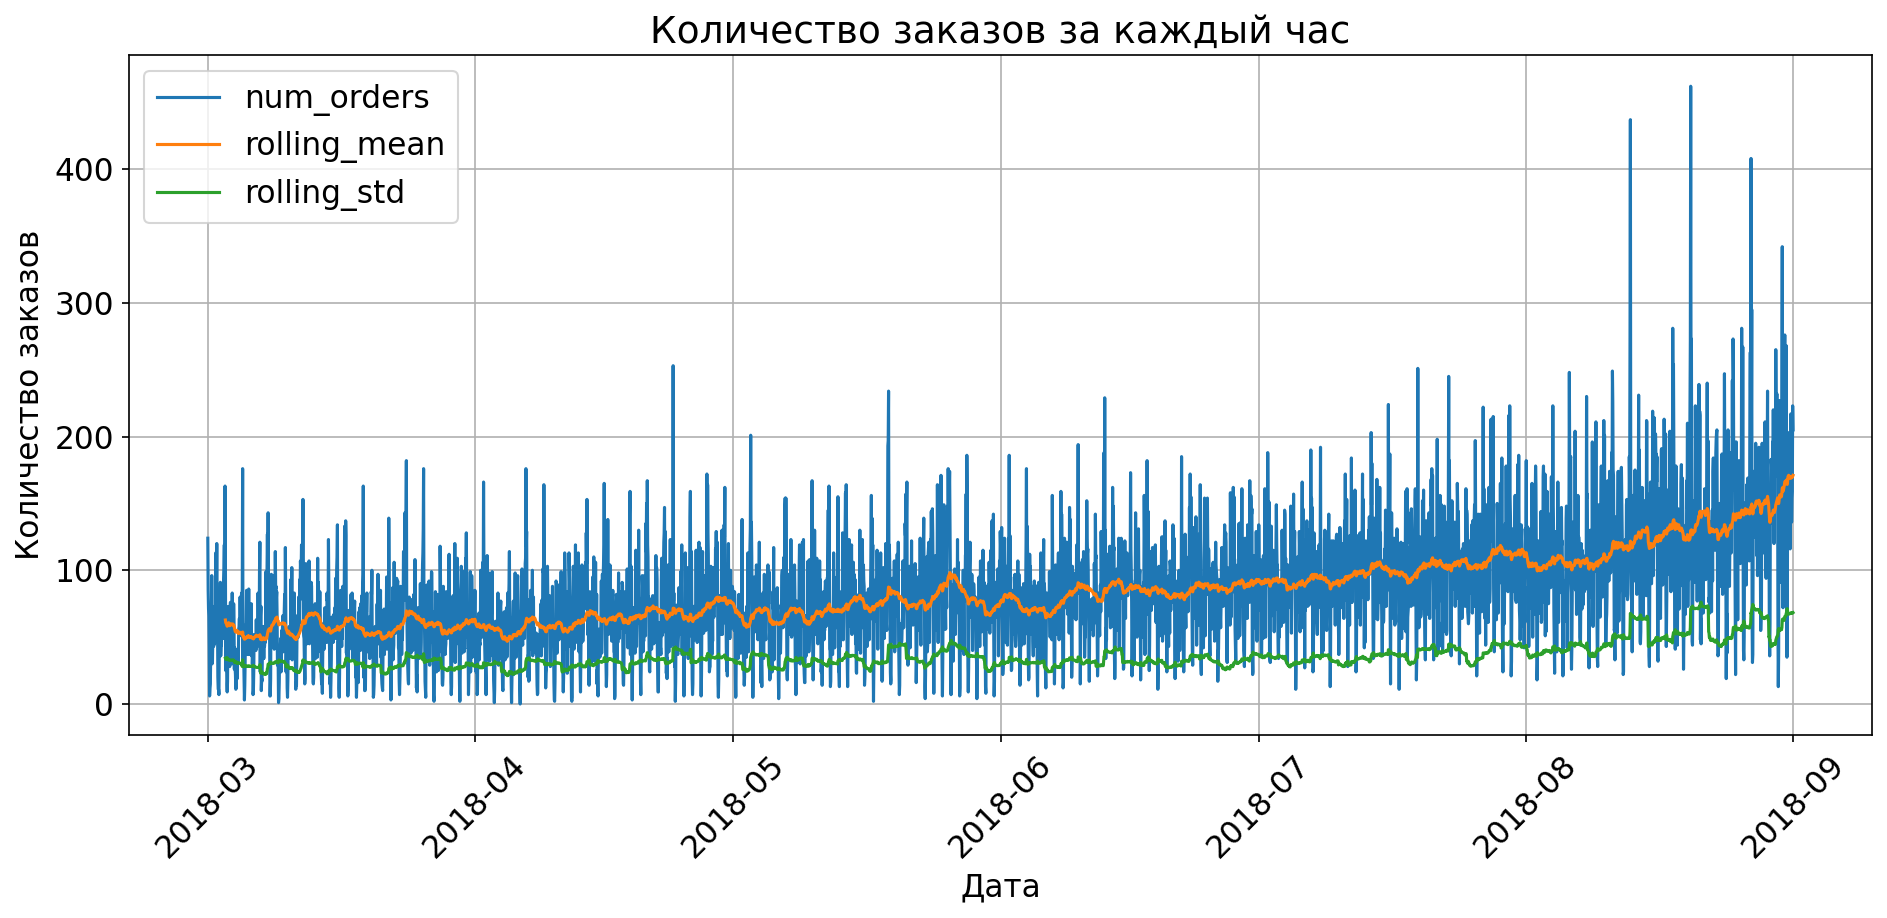

In [12]:
standart_plot(df_resampled,
              title='Количество заказов за каждый час', 
              xlabel='Дата', 
              ylabel='Количество заказов')

По скользящему среднему виден тренд увеличения количества заказов на временном отрезке. Разложим наш ряд на тренд и сезонность, чтобы увидеть изменеия более подробно.

In [13]:
# удалим вспомогательные столбцы из датафрейма, для удобства дальнейшего использования

df_resampled = df.resample('1H').sum()

<a id='part_3_2'></a>
## 3.2 Тренд и сезонность [▴](#head)

In [14]:
decomposed = seasonal_decompose(df_resampled)

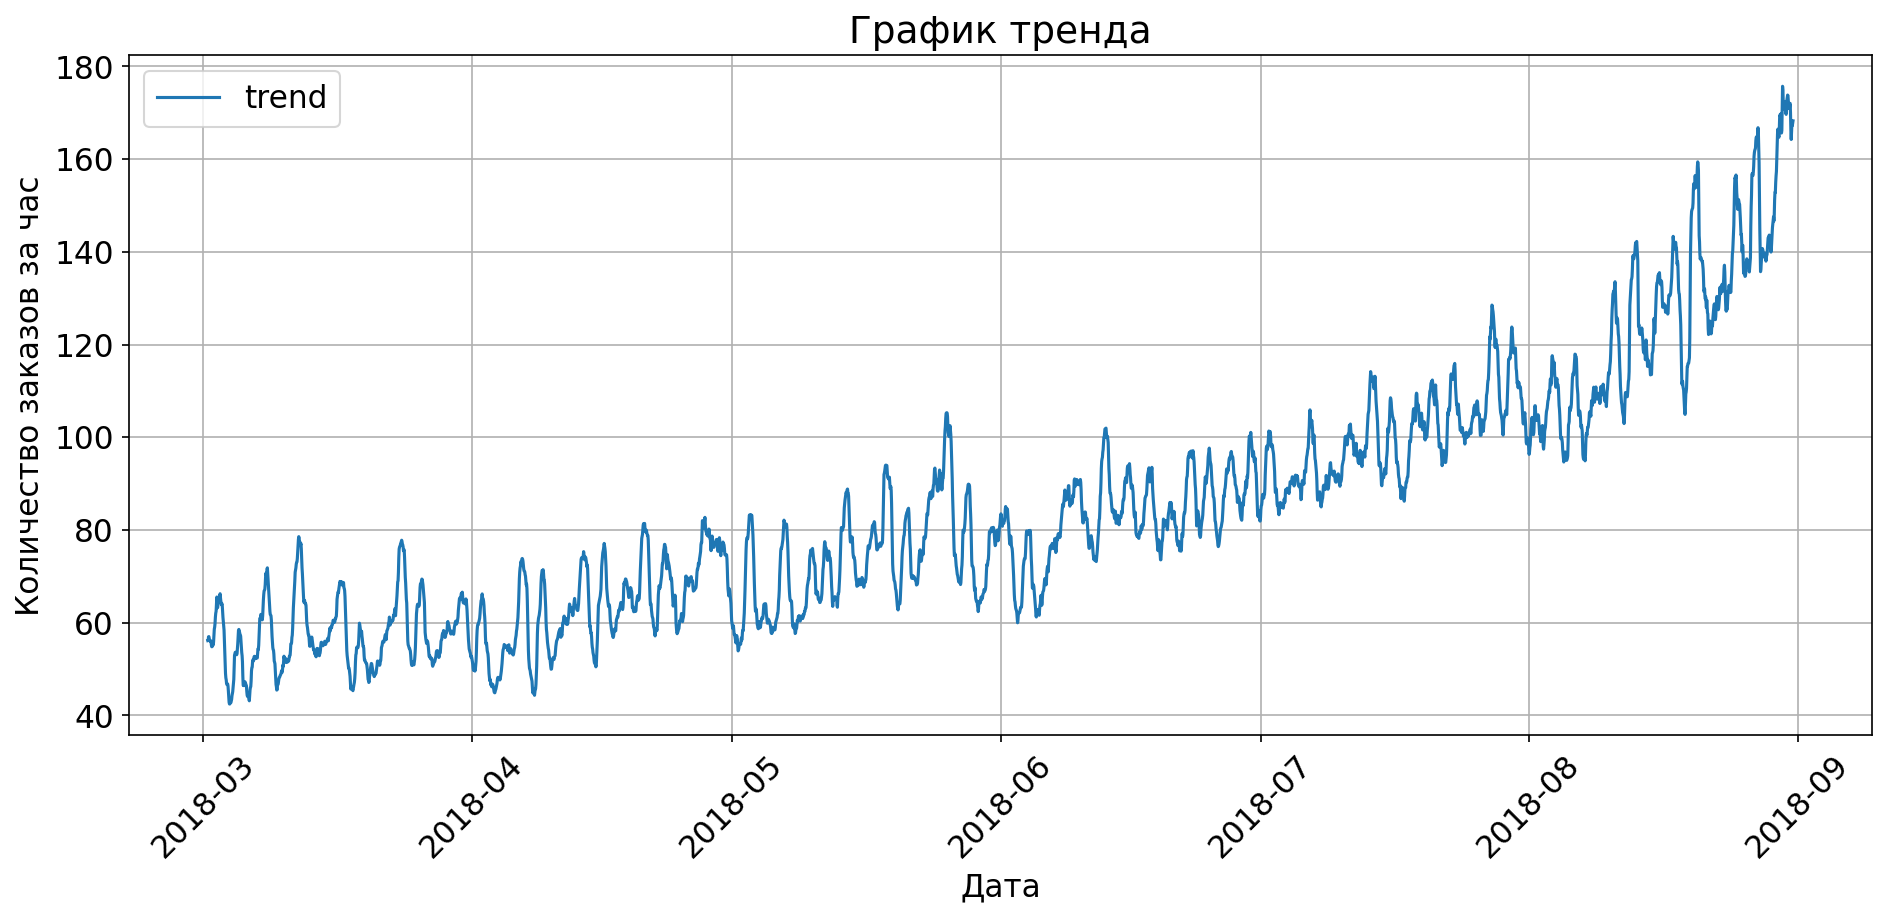

In [15]:
standart_plot(pd.DataFrame(decomposed.trend),
             title='График тренда',
             xlabel='Дата',
             ylabel='Количество заказов за час')

Видим четкий тренд увеличения количества заказов к концу лета. 

Количество заказов в среднем увеличилось с `60` до `160` в час за пол года.

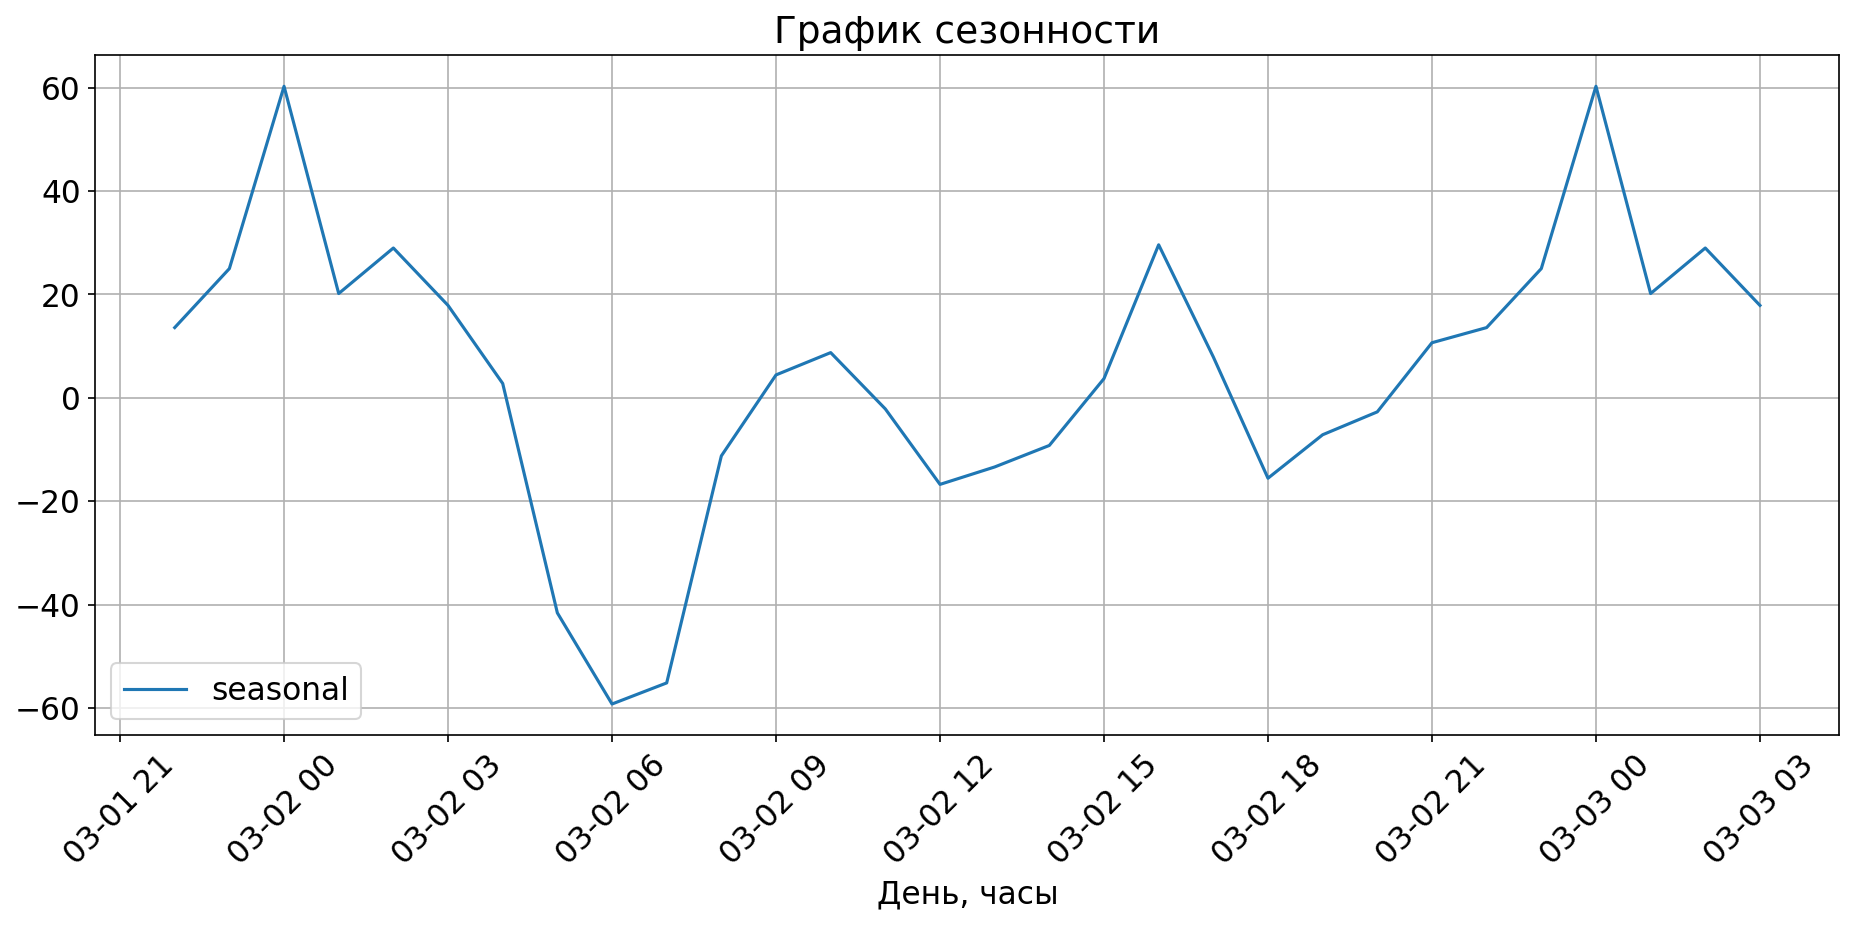

In [16]:
standart_plot(pd.DataFrame(decomposed.seasonal['2018-03-01 22:00':'2018-03-03 03:00']),
              title='График сезонности',
              xlabel='День, часы',
              ylabel='')

Сезонность заказов такси у нас составляет ровно сутки. 
- Пик заказов приходится на 12 ночи
- Самая низкая активность наблюдается в 6 часов утра

Такая сезонность связана с расписанием рейсов в аэропорту. Ночью самая высокая загруженность.

<a id='part_3_3'></a>
## 3.3 Аномальные значения [▴](#head)

Проверим наши данные на аномальные значения.

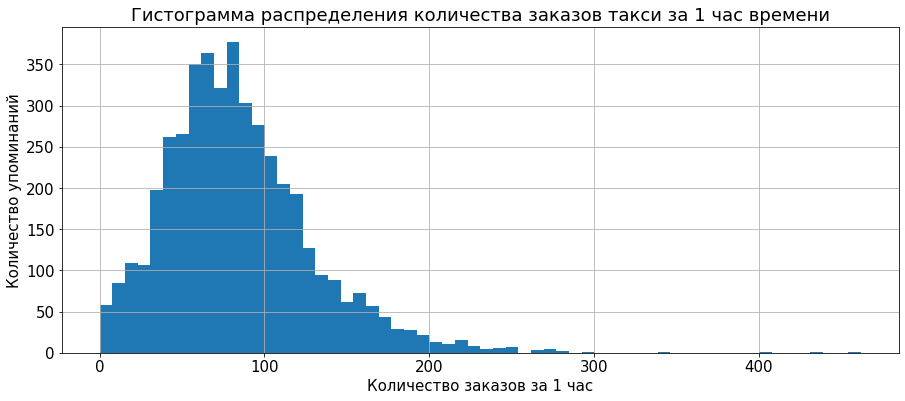

In [17]:
plt.figure(figsize=(15,6))
plt.hist(df_resampled, bins=60)
plt.title('Гистограмма распределения количества заказов такси за 1 час времени')
plt.xlabel('Количество заказов за 1 час')
plt.ylabel('Количество упоминаний')
plt.grid()
plt.show()

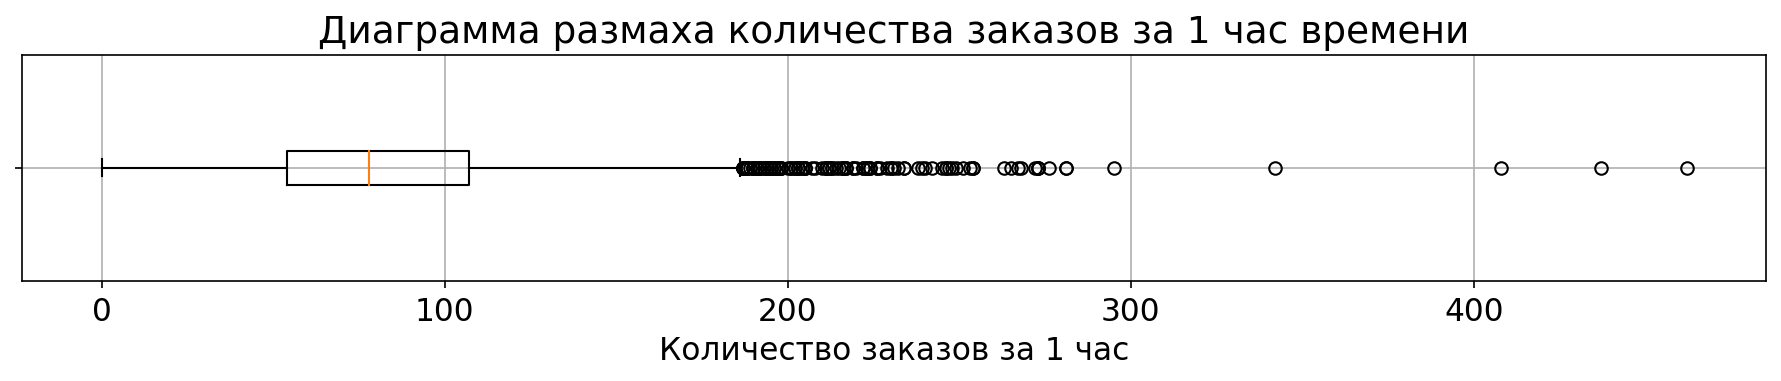

In [18]:
plt.figure(figsize=(15,2), dpi=150)
plt.boxplot(df_resampled, vert=False, labels=[''])
plt.title('Диаграмма размаха количества заказов за 1 час времени')
plt.xlabel('Количество заказов за 1 час')
plt.ylabel('')
plt.grid()
plt.show()

По диаграммам можно предположить, что значения выше `300` заказов в час являются выбросами. Возможно происходил сбой в учетной системе. Плюс такой резкий рост пропускной способности аэропорта в короткий промежуток времени вряд-ли возможен.

In [19]:
print(f'Количество аномальных значений превышающих 300 в час: {(df_resampled.num_orders > 300).sum()} шт.')

Количество аномальных значений превышающих 300 в час: 4 шт.


Заменим выбросы выше `300` средним значением.

In [20]:
df_resampled.loc[df_resampled['num_orders'] > 300, 'num_orders'] = df_resampled['num_orders'].mean()

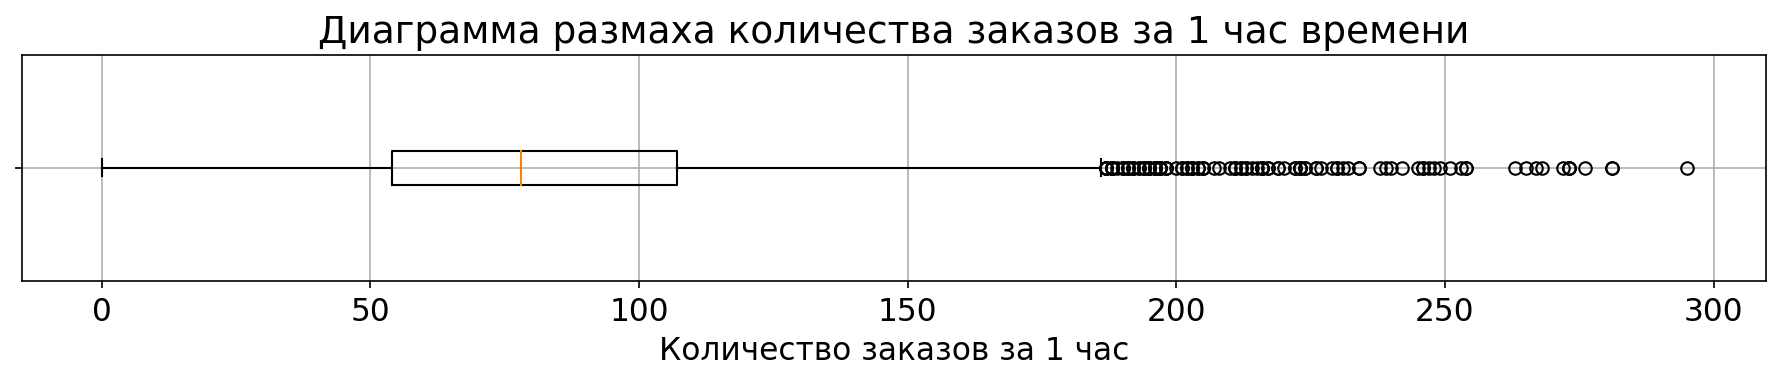

In [21]:
plt.figure(figsize=(15,2), dpi=150)
plt.boxplot(df_resampled, vert=False, labels=[''])
plt.title('Диаграмма размаха количества заказов за 1 час времени')
plt.xlabel('Количество заказов за 1 час')
plt.ylabel('')
plt.grid()
plt.show()

Избавились от выбросов. 

Теперь проанализируем, сможем ли мы сделать ряд более стационарным.

<a id='part_4'></a>
# 4. Обучение [▴](#head)

Для начала напишем пару функций.

Первая функция **`make_features`** - Позволит генерировать признаки в необходиомо объеме

**Принимает на вход**
- Датасет
- Количество сдвигов `max_lag`
- Размер окна для скользящего среднего `rolling_mean_size`

**Возвращает**
- Новый датасет с добавленными признаками
    - день недели `dayofweek`
    - час `hour`
    - скользящее среднее `rolling_mean` с указанным окном `rolling_mean_size`
    - скользящее стандартное отклонение `rolling_std` с указанным окном `rolling_mean_size`
    - указанное количество сдвигов `max_lag`

In [28]:
def make_features(data, max_lag, rolling_mean_size):
    
    features = data.copy()
    features['dayofweek'] = data.index.dayofweek
    features['hour'] = data.index.hour
    features['rolling_mean'] = features['num_orders'].shift().rolling(rolling_mean_size).mean()
    features['rolling_std'] = features['num_orders'].shift().rolling(rolling_mean_size).std()
    
    for lag in range(1, max_lag + 1):
        features[f'lag_{lag}'] = features['num_orders'].shift(lag)

    return features

Функция **`auto_grid`** - для автоматизации поиска лучших гиперпараметров

**Принимает на вход:**
- модель
- параметры для модели

**Выдает:**
- Лучший `score` модели
- Набор гиперпараметров, на которых этот результат был получен

In [29]:
def auto_grid(search_model, params):
    
    tscv = TimeSeriesSplit(n_splits=6)
    
    grid_search = GridSearchCV(estimator=search_model,
                               param_grid=params,
                               cv=tscv,
                               scoring='neg_root_mean_squared_error',
                               n_jobs=-1)
    
    grid_search.fit(X_train, y_train)
    
    print(f'Лучший score модели: {grid_search.best_score_:.3f}')
    print(f'Параметры лучшей модели: {grid_search.best_params_}')

<a id='part_4_1'></a>
## 4.1 Генерируем признаки [▴](#head)

Воспользуемся нашей функцией

In [30]:
df_features = make_features(df_resampled, 15, 20)

In [31]:
df_features.info()
df_features.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   float64
 1   dayofweek     4416 non-null   int64  
 2   hour          4416 non-null   int64  
 3   rolling_mean  4396 non-null   float64
 4   rolling_std   4396 non-null   float64
 5   lag_1         4415 non-null   float64
 6   lag_2         4414 non-null   float64
 7   lag_3         4413 non-null   float64
 8   lag_4         4412 non-null   float64
 9   lag_5         4411 non-null   float64
 10  lag_6         4410 non-null   float64
 11  lag_7         4409 non-null   float64
 12  lag_8         4408 non-null   float64
 13  lag_9         4407 non-null   float64
 14  lag_10        4406 non-null   float64
 15  lag_11        4405 non-null   float64
 16  lag_12        4404 non-null   float64
 17  lag_13        4403 non-null

,num_orders,dayofweek,hour,rolling_mean,rolling_std,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15
datetime,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124.0,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85.0,3,1,NaN,NaN,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71.0,3,2,NaN,NaN,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66.0,3,3,NaN,NaN,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43.0,3,4,NaN,NaN,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<a id='part_4_2'></a>
## 4.2 Создаем выборки [▴](#head)

### Выборки train и test

In [32]:
train, test = train_test_split(df_features, 
                                shuffle=False, 
                                test_size=0.1)

train = train.dropna() # удалим образовавшиеся NaN значения

print('Временные промежутки выборок:')
print(f'train: От {train.index.min()}     До {train.index.max()}')
print(f'test: От {test.index.min()}     До {test.index.max()}')

Временные промежутки выборок:
train: От 2018-03-01 20:00:00     До 2018-08-13 13:00:00
test: От 2018-08-13 14:00:00     До 2018-08-31 23:00:00


### Выборки features и target

In [33]:
X_train = train.drop(columns=['num_orders'])
y_train = train['num_orders']

X_test = test.drop(columns=['num_orders'])
y_test = test['num_orders']

In [34]:
def part_of_df(X, y, title):
    print(f'\nДоля: {len(X) / len(df_resampled):.2f} | X: {X.shape} - {title}')
    print(f'Доля: {len(y) / len(df_resampled):.2f} | y: {y.shape} - {title}')

In [35]:
print('Размеры выборок:\n')

print(f'{df_resampled.shape} - df_learn')

part_of_df(X_train, y_train, 'Тренировочная')
part_of_df(X_test, y_test, 'Тестовая')

Размеры выборок:

(4416, 1) - df_learn

Доля: 0.90 | X: (3954, 19) - Тренировочная
Доля: 0.90 | y: (3954,) - Тренировочная

Доля: 0.10 | X: (442, 19) - Тестовая
Доля: 0.10 | y: (442,) - Тестовая


<a id='part_4_3'></a>
## 4.3 Обучение моделей [▴](#head)

Для начала создадим пару списков для сбора результатов, а так же зададим кроличество выборок для кросс валидации.

In [36]:
models = []
results = []
tscv = TimeSeriesSplit(n_splits=6)

### Модель - Linear Regression

In [37]:
model_LR = LinearRegression()

scores = cross_val_score(model_LR,
                         X_train, y_train,
                         scoring='neg_root_mean_squared_error',
                         cv=tscv,
                         n_jobs=-1)

mean_score = np.mean(scores)

models.append('Linear Regression')
results.append(abs(mean_score))

print(f'Mean nRMSE: {mean_score:.3f}')

Mean nRMSE: -32.344


### Модель - Decision Tree Regressor

In [38]:
model = DecisionTreeRegressor(random_state=12345)
params = {'max_depth': [15, 20, 30, 40],
          'min_samples_leaf': [9, 12, 15],
          'min_samples_split': [2, 3, 5]}

In [39]:
# %%time
# auto_grid(model, params)
# print()

    Лучший score модели: -29.109
    Параметры лучшей модели: {'max_depth': 15, 'min_samples_leaf': 15, 'min_samples_split': 2}
    Wall time: 1.34 s

In [40]:
model_DT = DecisionTreeRegressor(max_depth=15,
                                 min_samples_leaf=15,
                                 min_samples_split=2,
                                 random_state=12345)

scores = cross_val_score(model_DT, 
                         X_train, y_train,
                         scoring='neg_root_mean_squared_error',
                         cv=tscv,
                         n_jobs=-1)

mean_score = np.mean(scores)

models.append('Decision Tree Regressor')
results.append(abs(mean_score))

print(f'Mean nRMSE: {mean_score:.3f}')

Mean nRMSE: -28.751


### Модель - XGBoost

In [41]:
model = xgb.XGBRegressor(random_state=12345)
params = {'max_depth': [3, 6, 9],
          'n_estimators': [300, 400],
          'learning_rate': [0.1, 0.01]}

In [42]:
# %%time
# auto_grid(model, params)
# print()

    Лучший score модели: -25.036
    Параметры лучшей модели: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 400}
    Wall time: 19.1 s

In [43]:
model_XGB = xgb.XGBRegressor(random_state=12345,
                             max_depth=3,
                             n_estimators=400,
                             learning_rate=0.1)

scores = cross_val_score(model_XGB, 
                         X_train, y_train,
                         scoring='neg_root_mean_squared_error',
                         cv=tscv,
                         n_jobs=-1)

mean_score = np.mean(scores)

models.append('XGBoost')
results.append(abs(mean_score))

print(f'Mean nRMSE: {mean_score:.3f}')

Mean nRMSE: -25.020


### Модель - Light GBM

In [44]:
model = lgb.LGBMRegressor(random_state=12345)
params = {'max_depth': [6, 12, 20],
          'n_estimators': [500, 1000, 2000],
          'learning_rate': [0.1, 0.05, 0.01]}

In [45]:
# %%time
# auto_grid(model, params)
# print()

    Лучший score модели: -24.822
    Параметры лучшей модели: {'learning_rate': 0.01, 'max_depth': 12, 'n_estimators': 1000} 
    Wall time: 35.9 s

In [46]:
model_LGBM = lgb.LGBMRegressor(random_state=12345,
                               learning_rate=0.01,
                               max_depth=12,
                               n_estimators=1000)

scores = cross_val_score(model_LGBM, 
                         X_train, y_train,
                         scoring='neg_root_mean_squared_error',
                         cv=tscv,
                         n_jobs=-1)

mean_score = np.mean(scores)

models.append('Light GBM')
results.append(abs(mean_score))

print(f'Mean nRMSE: {mean_score:.3f}')

Mean nRMSE: -24.866


### Модель - CatBoost

In [47]:
model = CatBoostRegressor(loss_function="RMSE", random_state=12345, verbose=False)
params = {'iterations': [500, 1000],
          'depth': [5, 10],
          'learning_rate': [0.1, 0.01]}

In [48]:
# %%time
# auto_grid(model, params)
# print()

    Лучший score модели: -24.720
    Параметры лучшей модели: {'depth': 5, 'iterations': 500, 'learning_rate': 0.1}
    Wall time: 4min 16s

In [49]:
model_CB = CatBoostRegressor(loss_function='RMSE',
                             random_state=12345, 
                             verbose=False,
                             depth=5,
                             iterations=500,
                             learning_rate=0.1)

scores = cross_val_score(model_CB, 
                         X_train, y_train,
                         scoring='neg_root_mean_squared_error',
                         cv=tscv,
                         n_jobs=-1)

mean_score = np.mean(scores)

models.append('CatBoost')
results.append(abs(mean_score))

print(f'Mean nRMSE: {mean_score:.3f}')

Mean nRMSE: -24.720


<a id='part_4_4'></a>
## 4.4 Проверка модели на адекватность [▴](#head)

In [50]:
model_D = DummyRegressor()

scores = cross_val_score(model_D, 
                         X_train, y_train,
                         scoring='neg_root_mean_squared_error',
                         cv=tscv,
                         n_jobs=-1)

mean_score = np.mean(scores)

models.append('Dummy Regressor')
results.append(abs(mean_score))

print(f'Mean nRMSE: {mean_score:.3f}')

Mean nRMSE: -39.666


<a id='part_4_conclusions'></a>
## Выводы [▴](#head)

Сделам датафрейм с результатами

In [51]:
results_df = pd.DataFrame(results, 
                          index=models, 
                          columns=['RMSE']).sort_values('RMSE')

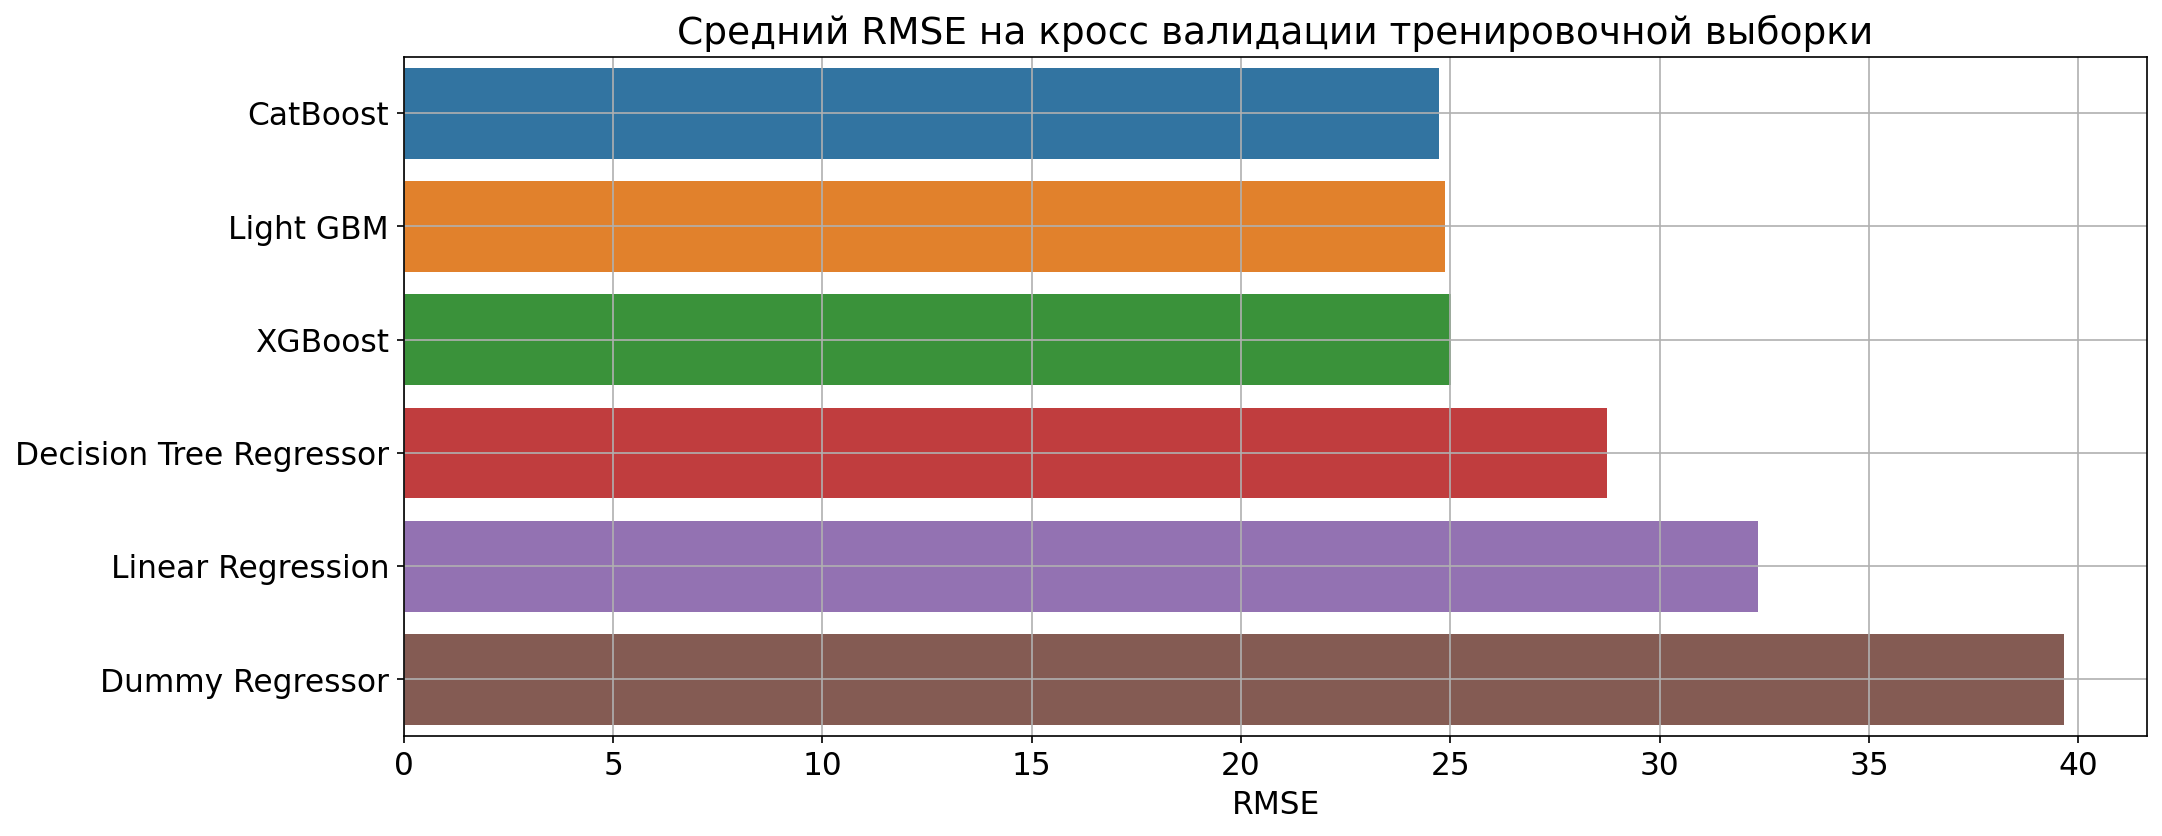

In [52]:
plt.figure(figsize=(15,6), dpi=150)

sns.barplot(y=results_df.index,
            x=results_df['RMSE'],
            orient='h')

plt.title('Средний RMSE на кросс валидации тренировочной выборки')
plt.xlabel('RMSE')
plt.grid()
plt.show()

В нашей задаче примерно на одном уровне выступили модели `CatBoost`, `Light GBM` и `XGBoost`. Для итогового тестирования выберем модель `CatBoost`, она хоть и незначительно, но опередила другие модели. Если бы у нас стояла задача учитывать скорость обучения моделей, то выбор был бы сделан на самую быструю из этих трех.

При проверке модели на адекватность `DummyRegressor` выдал `RMSE` сильно отстающий от любых других моделей. По этому можно считать что наши модели обучились адекватно.

<a id='part_5'></a>
# 5. Тестирование [▴](#head)

<a id='part_5_1'></a>
## 5.1 Получение предсказаний [▴](#head)

Лучшей моделью оказалась `CatBoostRegressor` получим с помощью нее предсказания на тестовой выборке.

In [53]:
model_CB = CatBoostRegressor(loss_function='RMSE',
                             random_state=12345, 
                             verbose=False,
                             depth=5,
                             iterations=500,
                             learning_rate=0.1)

model_CB.fit(X_train, y_train)

predict = model_CB.predict(X_test)
print(f'RMSE: {mean_squared_error(y_test, predict, squared=False)}')

RMSE: 38.56193502584429


Создадим датафреймы для удобства анализа.

In [54]:
df_target = pd.DataFrame(y_test)
df_predicted = pd.DataFrame(predict, index=y_test.index, columns=['num_orders'])

Проанализируем значения предсказаний

In [55]:
df_predicted.describe()

,num_orders
count,442.000000
mean,123.236688
std,37.369482
min,31.206468
25%,100.035302
50%,124.887886
75%,143.466892
max,239.602895


Аномальных значений нет, это хорошо.

<a id='part_5_2'></a>
## 5.2 Сравнение графиков [▴](#head)

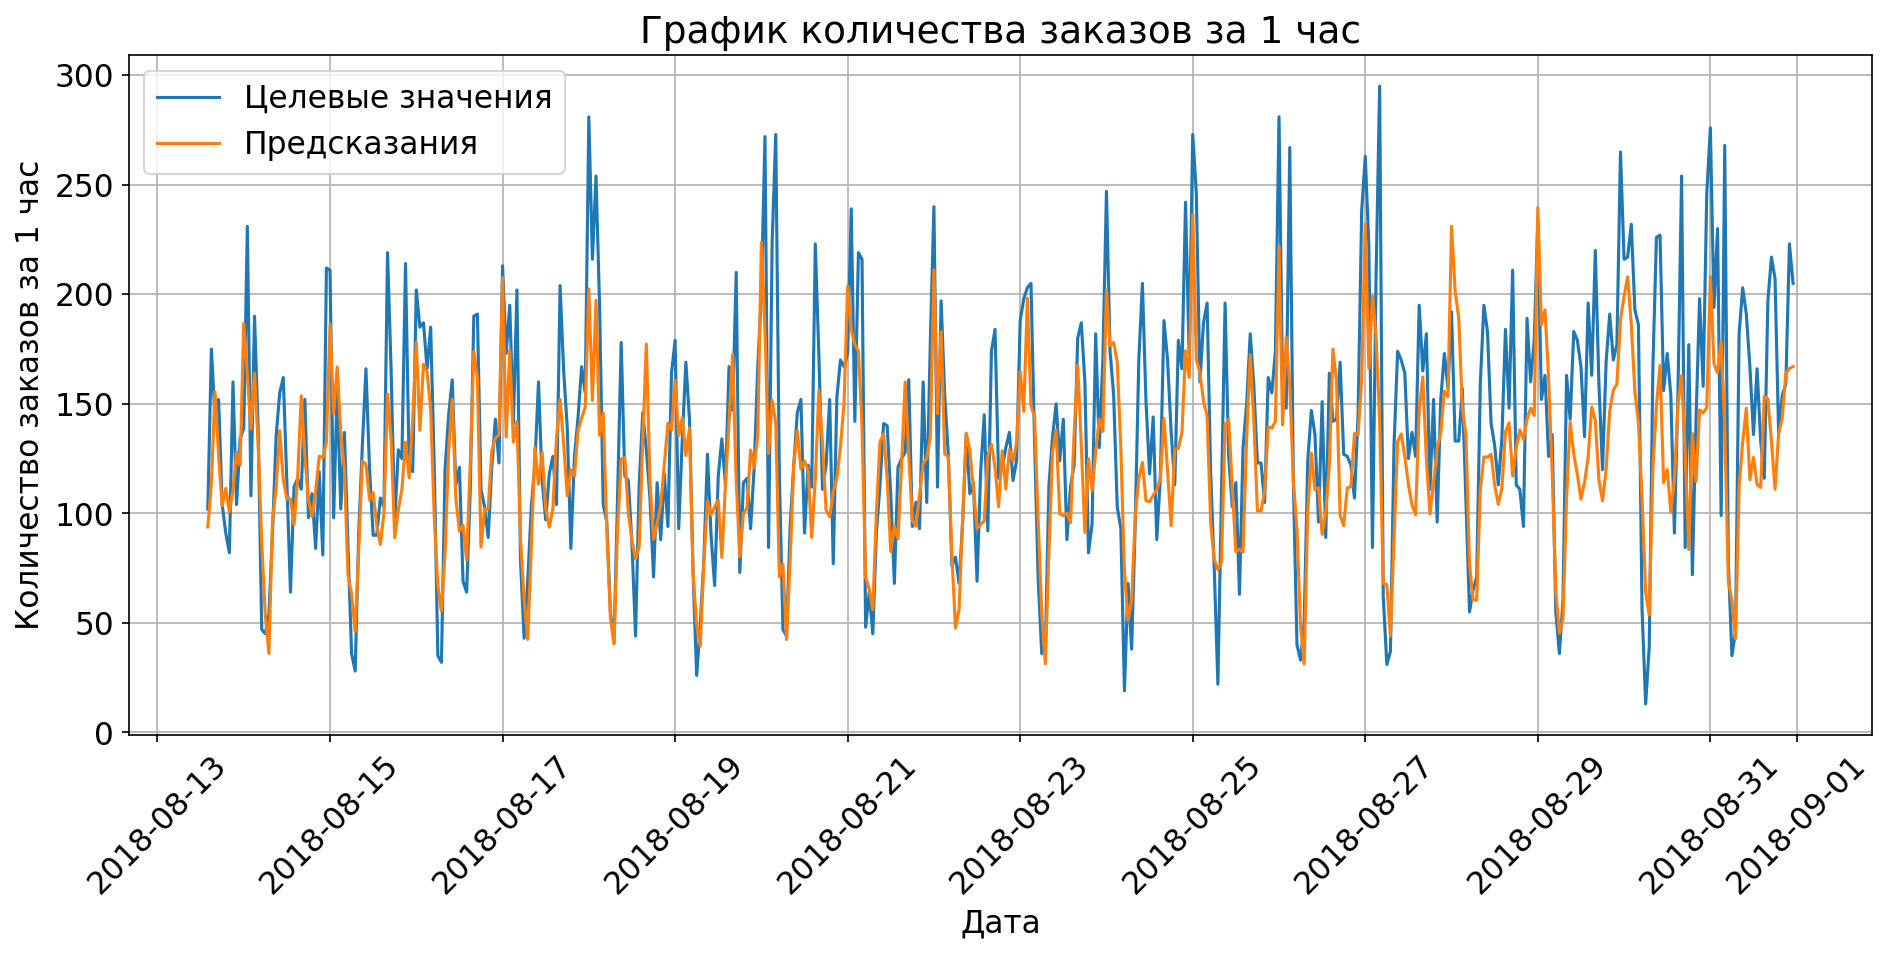

In [57]:
plt.figure(figsize=(15,6), dpi=150)
plt.plot(df_target)
plt.plot(df_predicted)
plt.title('График количества заказов за 1 час')
plt.xlabel('Дата')
plt.ylabel('Количество заказов за 1 час')
plt.grid()
plt.legend(('Целевые значения', 'Предсказания'))
plt.xticks(rotation=45)
plt.show()

Графики целевых значений и предскапзаний выглядят очень похоже. Видны сильные расхождения на больших всплесках. 

Еще видно, что чем дальше в хронологическом порядке дата предсказания, тем выше расхождения между предсказанными значениями и целевыми.

Теперь сравним тренд и сезонность.

In [58]:
decomposed_predicted = seasonal_decompose(df_predicted)
decomposed_target = seasonal_decompose(df_target)

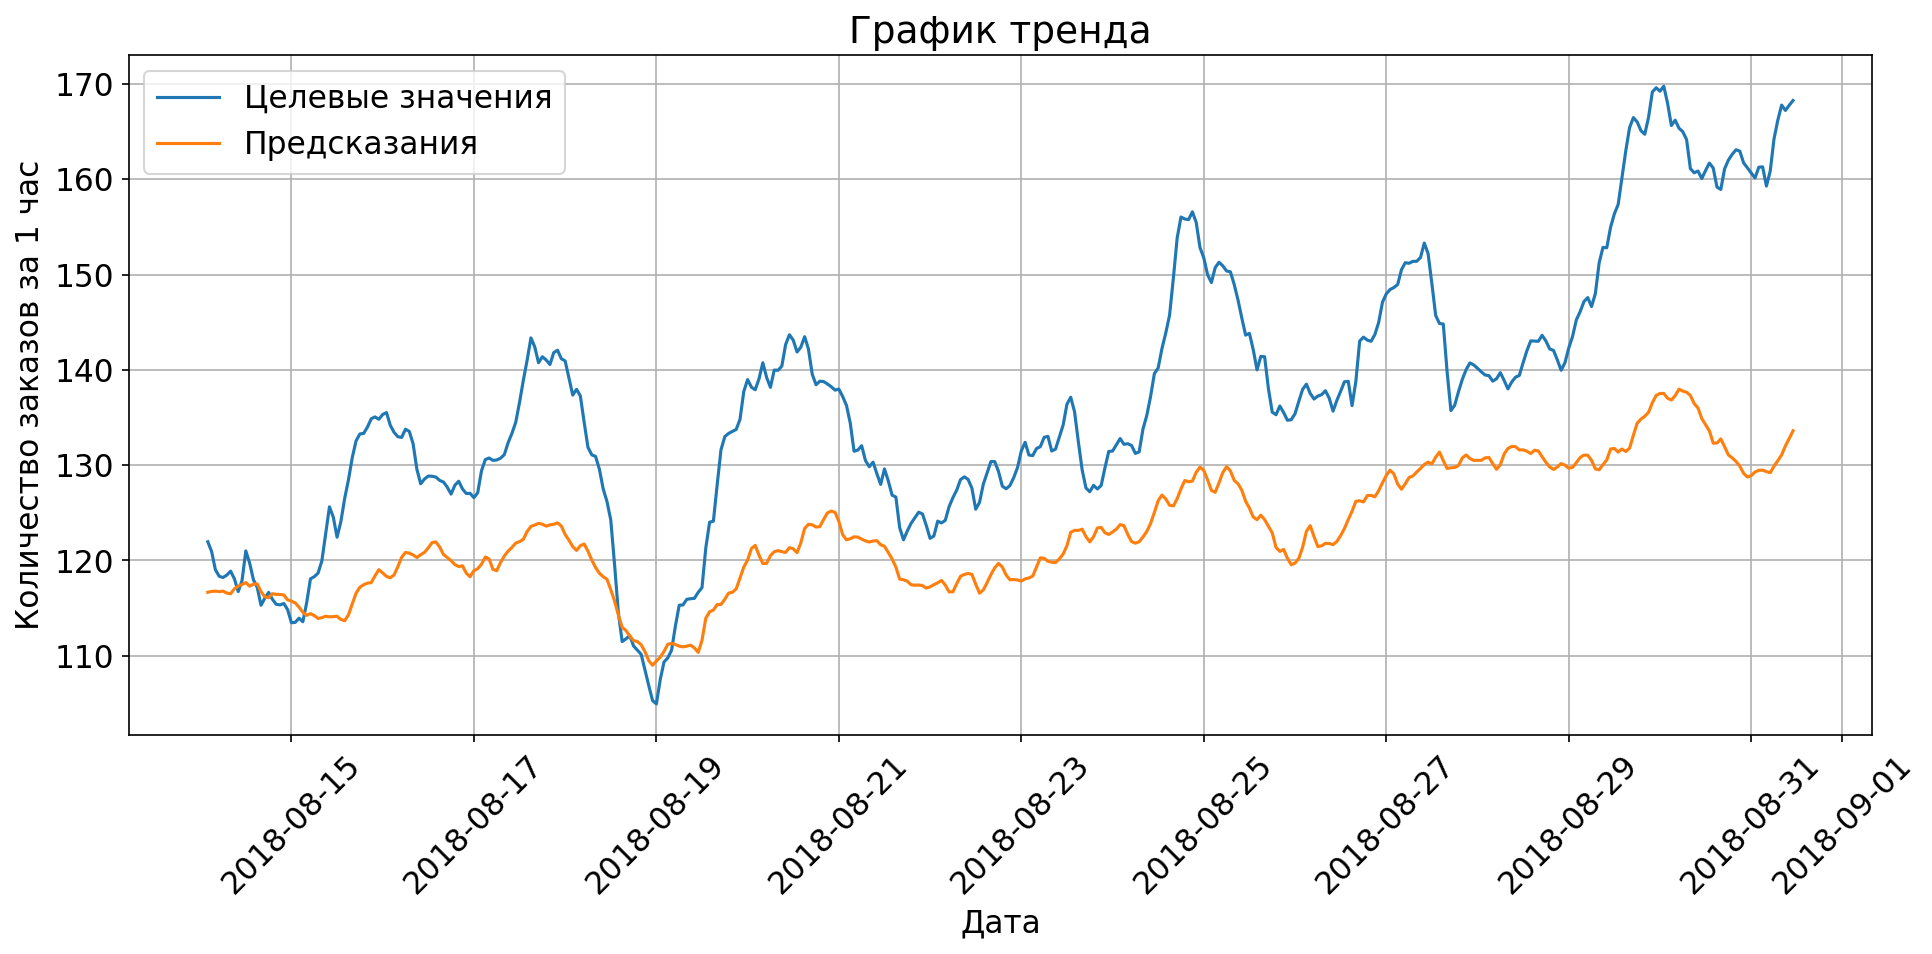

In [59]:
plt.figure(figsize=(15,6), dpi=150)
plt.plot(decomposed_target.trend)
plt.plot(decomposed_predicted.trend)
plt.title('График тренда')
plt.xlabel('Дата')
plt.ylabel('Количество заказов за 1 час')
plt.grid()
plt.legend(('Целевые значения', 'Предсказания'))
plt.xticks(rotation=45)
plt.show()

По графику тренда видно, что предсказания как правило ниже чем целевые значения. Расхождения целевых и предсказанных значений со временем растут.

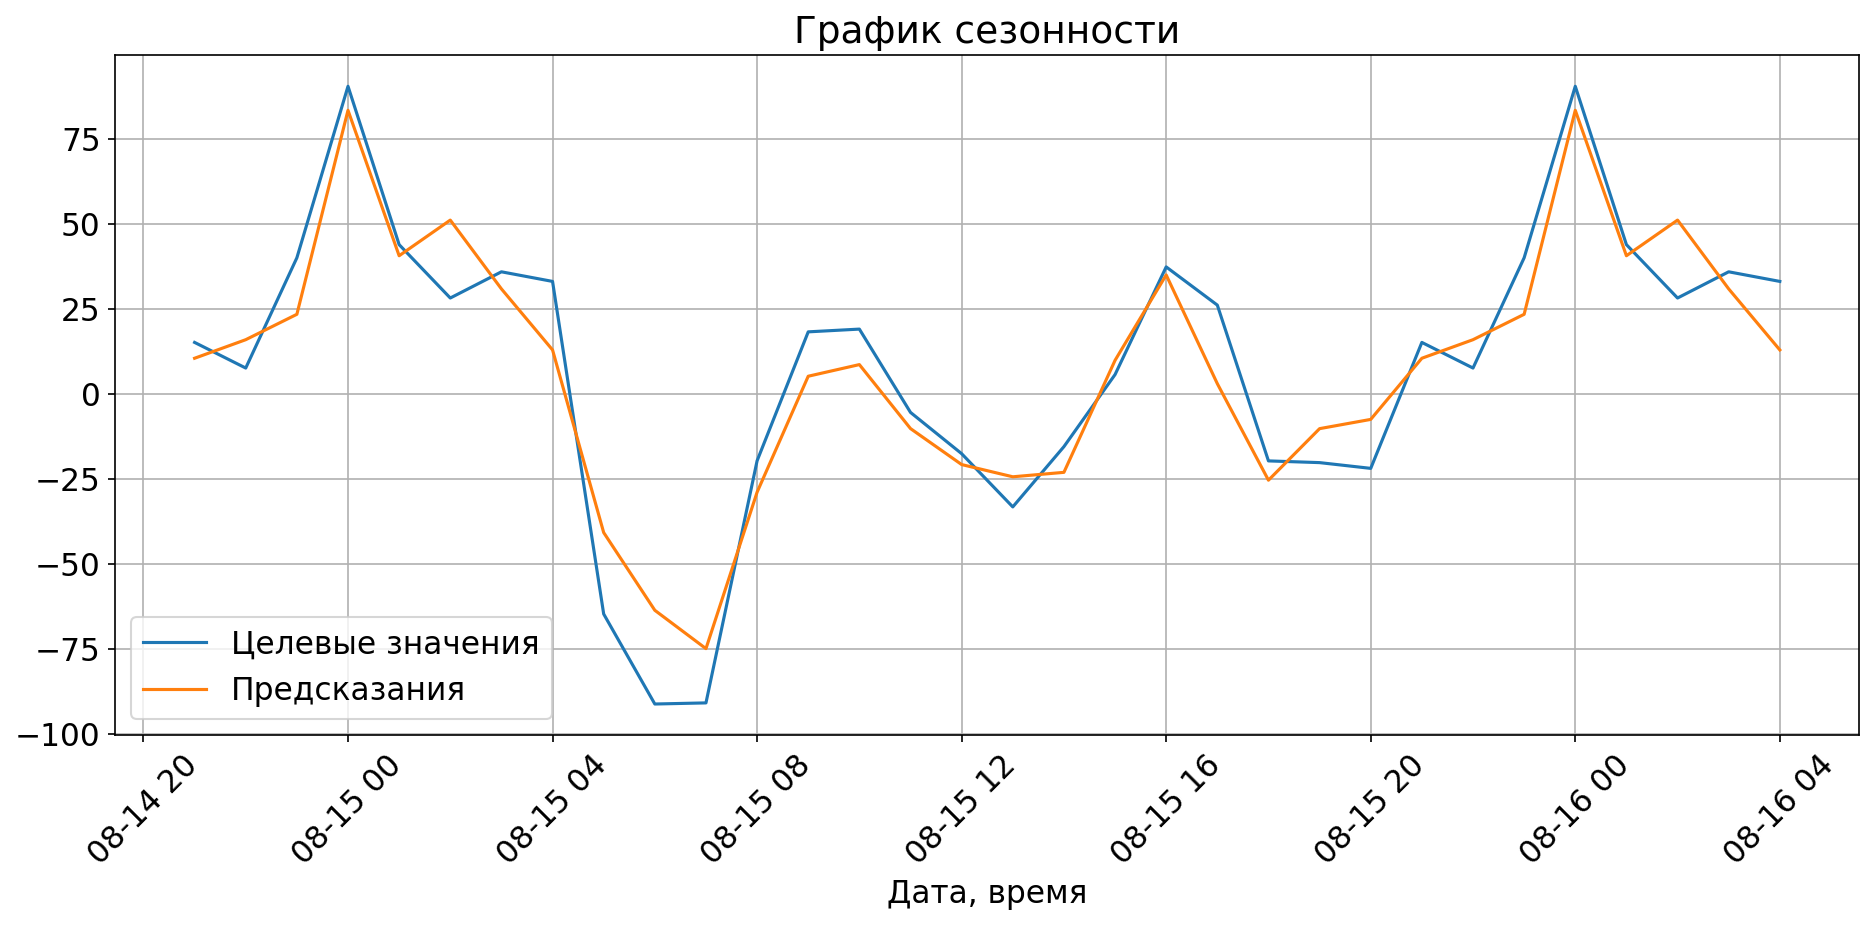

In [60]:
plt.figure(figsize=(15,6), dpi=150)
plt.plot(decomposed_target.seasonal['2018-08-14 21:00':'2018-08-16 04:00'])
plt.plot(decomposed_predicted.seasonal['2018-08-14 21:00':'2018-08-16 04:00'])
plt.title('График сезонности')
plt.xlabel('Дата, время')
plt.ylabel('')
plt.grid()
plt.legend(('Целевые значения', 'Предсказания'))
plt.xticks(rotation=45)
plt.show()

А вот сезоность практически идеально совпала. Это говорит нам о том, что в целом модель возвращает нам адекватные предсказания. И не нагенерит нам пиковых значений во время низкого спроса и наоборот.

<a id='part_5_conclusions'></a>
## Выводы [▴](#head)

- Для нашей задачи мы выполнили ресемплирование временного ряда до `1` часа.
- Исходные данные оказались чистые, не было пропусков, однако попалось небольшое количество выбросов, которые мы заменили на среднее значение
- Для формирования признаков мы разбили наш временной ряд на `15 сдвигов`, это количество оказалось оптимальным для получения наилучшего качества модели.

- Лучший результат предсказания показала модель `CatBoost`, однако `Light GBM` и `XGBoost` тоже имели близкие к `CatBoost` показатели качества, и если бы скорость обучения была бы одним из условий, выбор модели можно было бы пересмотреть.
- Подавляющая часть предсказанных значений оказались ниже чем целевые значения, необходимо это учитывать при запуске модели. Возможно имет смысл сделать небольшую корректировку в плюс, около `2-4%`, что еще бы увеличило точность предсказаний.
- Чем дальше предсказываются значения в хронологическеом порядке, тем сильней промахивается модель, это необходимо учитывать при прогнозировании и не брать слишком большие промежутки для предсказания.

<a id='check_list'></a>
## Чек-лист готовности проекта [▴](#head)

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48